In [1]:
!git clone https://github.com/zxzhaixiang/QMDB

Cloning into 'QMDB'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 561 (delta 116), reused 141 (delta 73), pack-reused 354
Receiving objects: 100% (561/561), 267.69 MiB | 34.67 MiB/s, done.
Resolving deltas: 100% (291/291), done.
Checking out files: 100% (92/92), done.


In [0]:
datapath = './QMDB/data/processed_data/'
#datapath = './../data/processed_data/'

In [3]:
!pip install hiddenlayer

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
savepath = './gdrive/My Drive/'

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


In [9]:
torch.__version__

'1.1.0'

## Loading data and prepare data loader

In [10]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [0]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [14]:
genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
genres_list = list(genres_list)
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['history', 'western', 'thriller', 'fiction', 'mystery', 'family', 'crime', 'animation', 'romance', 'war', 'adventure', 'movie', 'horror', 'tv', 'action', 'documentary', 'music', 'science', 'comedy', 'fantasy', 'foreign', 'drama']


In [0]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

In [0]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding = pickle.load(f)

In [0]:
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding:
    kw_embedding[key] = torch.FloatTensor(kw_embedding[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [0]:
kw_set = set(kw_embedding.keys())

In [0]:
kw_by_movie = [[kw for kw in kws.split(' ')] for kws in movie_df['kws_all']]

In [0]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)/5
G    = torch.tensor(genres, dtype=torch.float)

In [0]:
batch_size = 4096
validation_split = .1
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*10).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

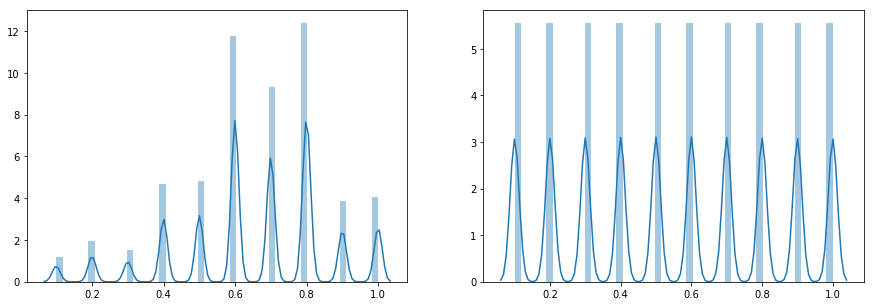

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [30]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [0]:
#ind = train_idx
ind = train_idx_resampled

train_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
ind = val_idx
val_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

        self.genres_layers = nn.Sequential(
                                nn.Linear(self.genres_dim, self.g_latent_dim)
        )
        
        self.fc_layers_relevance = nn.Sequential(
            nn.Linear(self.g_latent_dim + self.i_latent_dim + 64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, genres, em_query):
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        genres_em = self.genres_layers(genres)
        
        final_query_em = user_em + genres_em + em_query
        
        relevance_em = torch.cat((movie_em, genres_em, em_query), dim=2)
        relevance_em = relevance_em.view(-1,self.g_latent_dim + self.i_latent_dim + 64)

        relevance_score = self.fc_layers_relevance(relevance_em)

        return relevance_score.view(-1,1), torch.bmm(final_query_em, movie_em.view(-1,self.i_latent_dim, 1)).view(-1,1)

In [47]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 64, 'item_latent_dim': 64,
          'genre_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 64, 'item_latent_dim': 64, 'genre_latent_dim': 64}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_relevance_criterion = nn.BCELoss()

CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [50]:
count_parameters(CF)

545921

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator embedding_renorm because torch.onnx.symbolic.embedding_renorm does not exist
  .format(op_name, op_name))


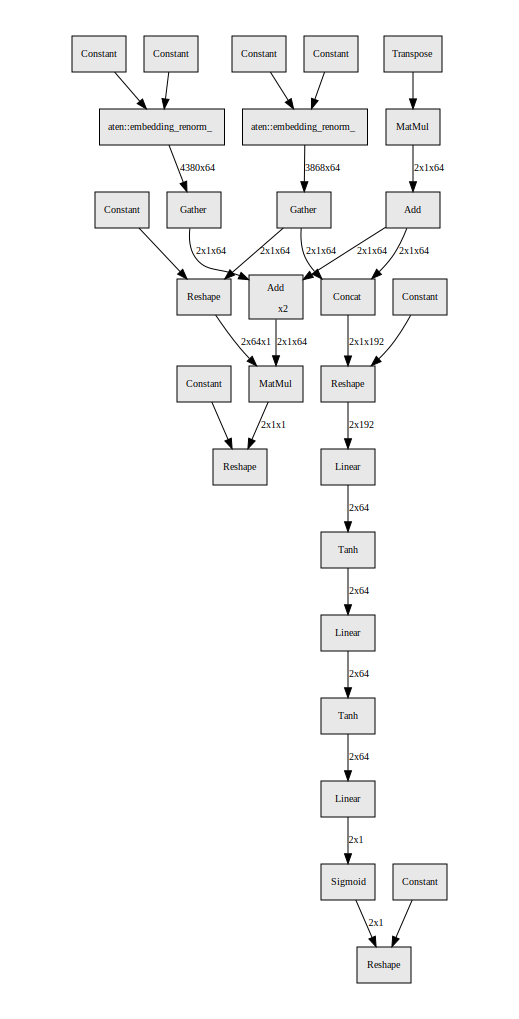

In [51]:
hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   )) #hr


In [52]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   ) #hr


(tensor([[0.4937],
         [0.4937]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[-0.1446],
         [-0.1446]], device='cuda:0', grad_fn=<ViewBackward>))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss_score=0, loss_relevance=0), display_id = True)

    def update(self, i, loss_score=0, loss_relevance=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss_score=loss_score, loss_relevance=loss_relevance))
    
    def progress(self, value, loss_score=0, loss_relevance=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss [rating={loss_score:0.5f}, relevance={loss_relevance:0.5f}] <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value, M=M, loss_score=loss_score, loss_relevance=loss_relevance))

In [54]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

1647 mini-batches in training dataset, 83 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.002
    elif(epoch<10):
        lr = 0.001
    elif (epoch<20):
        lr = 0.0005
    else:
        lr = 0.00025

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [0]:
G = G.to(device)

In [0]:
def get_irrelevant_movies(movies):
    res = np.random.choice(nM, movies.shape[0], replace=True)
    return torch.LongTensor(res).view(movies.shape)

In [0]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        if len(kw_list)==0:
            return kw_default_embedding
        else:
            res = torch.zeros(kw_default_embedding.shape)
            for kw in kw_list:
#                if kw in kw_set:
                res+=kw_embedding[kw]
            return res/len(kw_list)

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        kws = random.sample(kw_by_movie[i], random.randrange(len(kw_by_movie[i])))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [0]:
train_losses = []
train_rating_losses = []
train_relevance_losses = []

val_losses = []
val_rating_losses = []
val_relevance_losses = []

In [108]:
for epoch in range(epoch_num):
    
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    CF.train()
    
    tmp_loss_rating = 0
    tmp_loss_relevance = 0
    
    for i,(users, movies, ratings) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss_rating, tmp_loss_relevance)

        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movie = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[movies], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(rel_score, torch.ones(rel_score.shape).to(device)) + \
                         CF_relevance_criterion(irrel_score, torch.zeros(rel_score.shape).to(device)) 
        
        loss = 10*loss_rating + loss_relevance
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        train_losses.append(loss.item())
        train_rating_losses.append(loss_rating.item())
        train_relevance_losses.append(loss_relevance.item())
        
        tmp_loss_rating = loss_rating.item()
        tmp_loss_relevance = loss_relevance.item()        
    
    CF.eval()

    torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel_v04'))
    torch.save(CF.state_dict(), os.path.join('./cfmodel_v04'))

    for i, (u,m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        irrelevant_movie = get_irrelevant_movies(m)
        Q = get_query_tensor(m)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[m], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(rel_score, torch.ones(rel_score.shape).to(device)) + \
                         CF_relevance_criterion(irrel_score, torch.zeros(rel_score.shape).to(device)) 
        
        loss = loss_rating + loss_relevance

        val_losses.append(loss.item())
        val_rating_losses.append(loss_rating.item())
        val_relevance_losses.append(loss_relevance.item())
    
    print('epoch[{}/{}], train loss = {}=10x{} (rating) + {} (relevance), val loss = {}=10x{} (rating) + {} (relevance)'.
         format(epoch, epoch_num, train_losses[-1], train_rating_losses[-1], train_relevance_losses[-1], val_losses[-1], val_rating_losses[-1], val_relevance_losses[-1]))
    
    if (epoch%1==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

Training epoch 0/50


NameError: ignored

In [0]:
CF.eval()
torch.save(CF.state_dict(), './cfmodel_v04')
torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel_v04'))

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()
User_Em = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
ave_User_Em = User_Em.mean(axis=0, keepdims=True)

In [0]:
with open('./movie_embedding', 'wb') as f:
    pickle.dump(Movie_Em, f)
with open('./ave_user_embedding', 'wb') as f:
    pickle.dump(ave_User_Em, f)


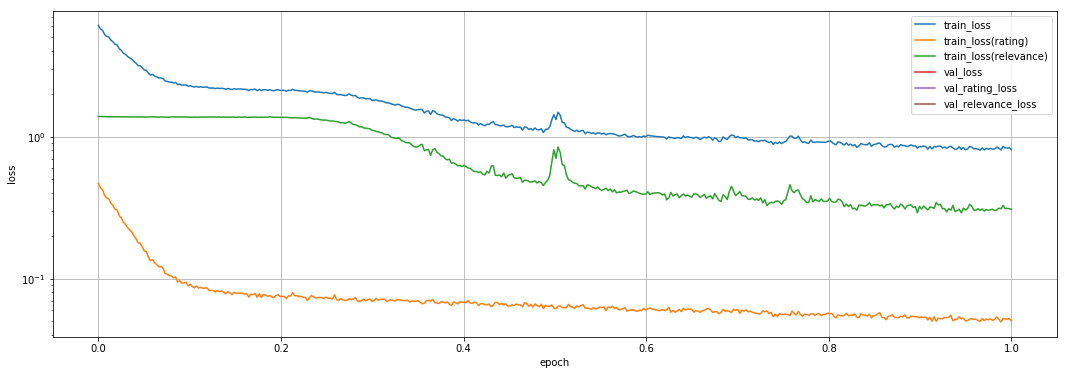

In [68]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch+1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch+1, len(train_rating_losses)),train_rating_losses,label='train_loss(rating)')
plt.plot(np.linspace(0,epoch+1, len(train_relevance_losses)),train_relevance_losses,label='train_loss(relevance)')
plt.plot(np.linspace(0,epoch+1, len(val_losses)),val_losses,label='val_loss')
plt.plot(np.linspace(0,epoch+1, len(val_rating_losses)),val_rating_losses,label='val_rating_loss')
plt.plot(np.linspace(0,epoch+1, len(val_relevance_losses)),val_relevance_losses,label='val_relevance_loss')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [69]:
r_real = []
r_pred = []

n_tp = 0
n_tn = 0
n_fp = 0
n_fn = 0


with torch.no_grad():
    for i, (u, m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        irrelevant_movie = get_irrelevant_movies(m)
        Q = get_query_tensor(m)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[m], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        r_real+=list(r.detach().cpu().numpy().reshape(-1))
        r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))
        
        rel_score = rel_score.detach().cpu().numpy().flatten()
        irrel_score = irrel_score.detach().cpu().numpy().flatten()
        
        n_tp += np.sum(rel_score>0.5)
        n_tn += np.sum(irrel_score<0.5)
        n_fp += np.sum(irrel_score>0.5)
        n_fn += np.sum(rel_score<0.5)
        
        if(i%20==0):
            print('{}/{}'.format(i,nBatch_val))

0/83
20/83
40/83
60/83
80/83


In [70]:
print('           | predict relevant  |  predict irrelevant')
print('relevant   |   %5d           |     %5d          ' % (n_tp, n_fn))
print('irrelevant |   %5d           |     %5d          ' % (n_fp, n_tn))

precision = n_tp/(n_tp+n_fp)
recall = n_tp/(n_tp+n_fn)
print('precision = %f' % precision)
print('recall = %f' % recall)

print('F1-score = %f' % (2/(1/precision+1/recall)))

           | predict relevant  |  predict irrelevant
relevant   |   326737           |      9170          
irrelevant |   24725           |     311182          
precision = 0.929651
recall = 0.972701
F1-score = 0.950689


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [73]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.05599123612046242, std = 0.20389427244663239
mae = 0.16677363216876984
rmse = 0.21144242584705353
slope=0.43169950640948, r2=0.47655045207142793
pearson = 0.4765504520714281, spearman = 0.47333090006322376


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

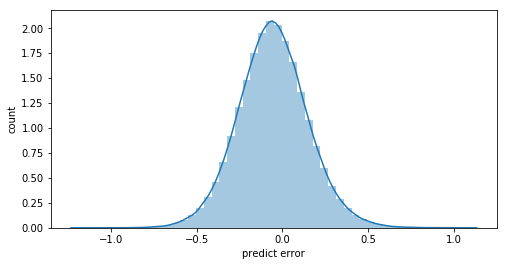

In [74]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [76]:
pd_df.head(50)

,real,pred,userId,movieId,index,Unnamed: 0,title,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,0.5,0.527401,4157,1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411,3.115572,0.743689
1,0.6,0.362688,406,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590,2.511017,1.496844
2,0.8,0.728099,332,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,729,3.279835,0.934984
3,0.2,0.152593,906,3085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1767,1.413413,0.976146
4,0.8,0.516769,364,2253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819,3.322955,1.289097
5,0.6,0.568555,190,2467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1305,2.599234,0.739652
6,0.8,0.557256,2233,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,670,2.935075,1.160141
7,0.6,0.374921,742,47,22.0,22.0,"Usual Suspects, The",22.0,629.0,1995.0,"thriller,crime,drama",clearplay twists r cast btaege amis flashback ...,3763.0,4.190141,0.811714,512,2.189453,1.083702
8,0.6,0.391296,1974,1871,657.0,657.0,Red Sonja,657.0,9626.0,1985.0,"action,fantasy,adventure",talisman swordplay pulp and sonja schwarzenegg...,700.0,2.315714,0.934345,1077,3.918292,0.618270
9,0.3,0.546575,2811,3498,1225.0,1225.0,"Fast and the Furious, The",1225.0,9799.0,2001.0,"action,crime,thriller",walker michelle duringcreditsstinger rob cohen...,2249.0,2.720098,1.068402,772,2.693653,1.315033


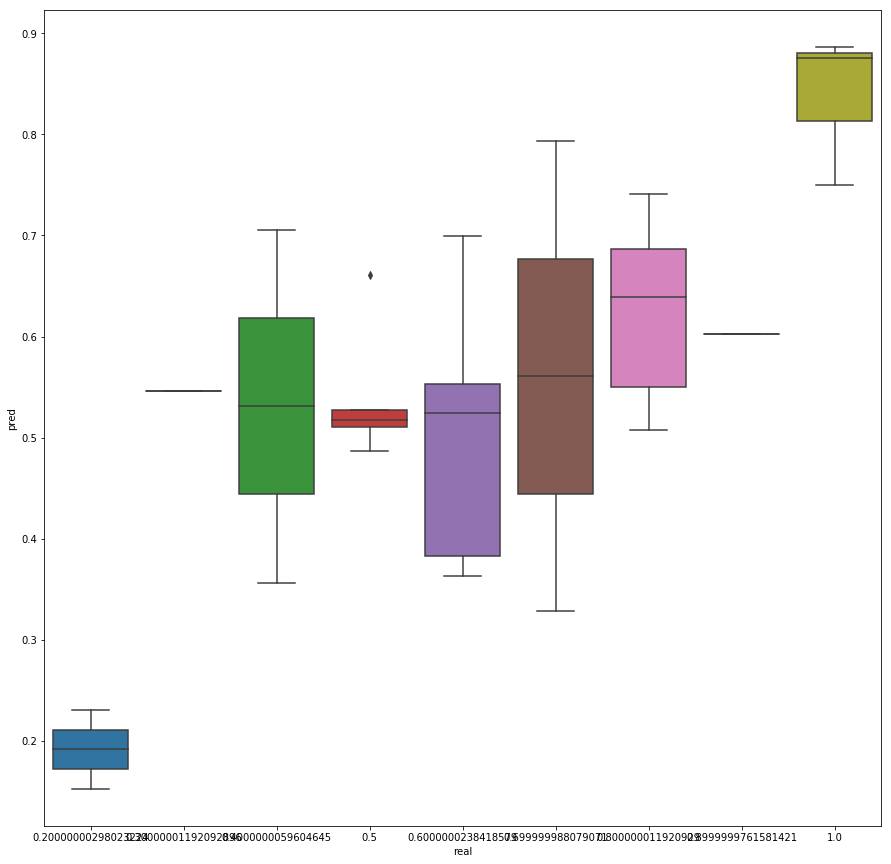

In [77]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

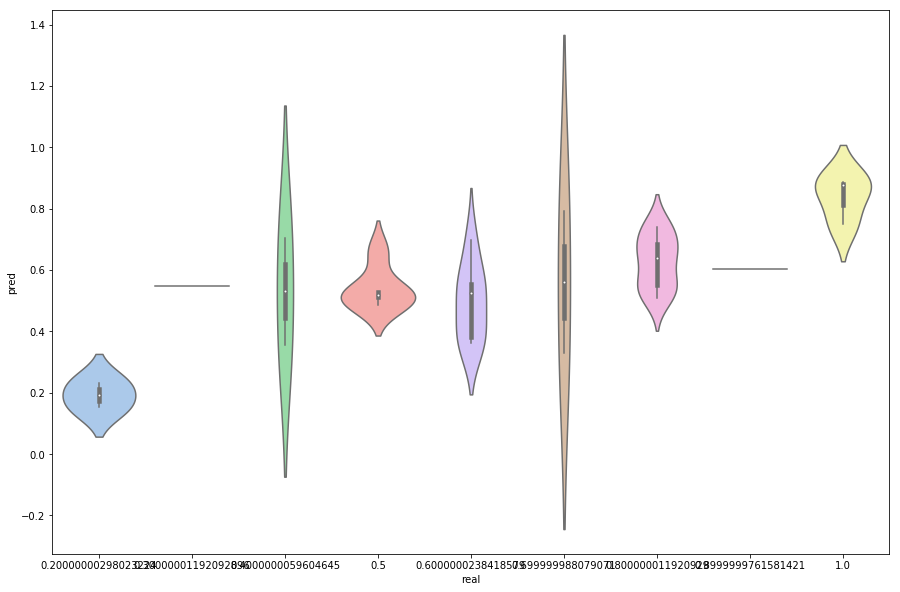

In [78]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


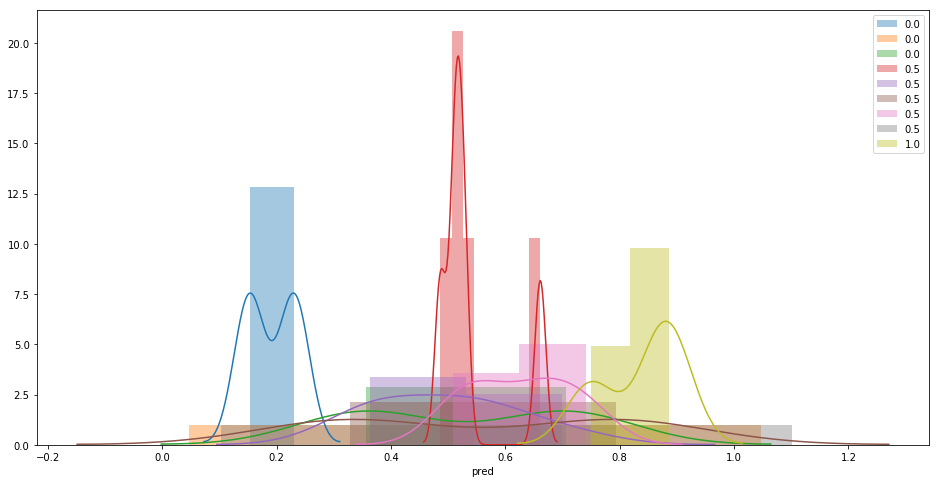

In [79]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
genre_weight = CF.genres_layers[0].weight.detach().cpu().numpy().T

pca = decomposition.PCA(n_components = 5)
G_std = StandardScaler().fit_transform(genre_weight)
G_pca = pca.fit_transform(G_std)

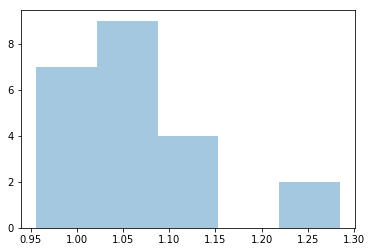

In [81]:
L = np.linalg.norm(genre_weight,axis=1,keepdims=True)
sns.distplot(L,kde=False)

(-4.502603, 5.21886)

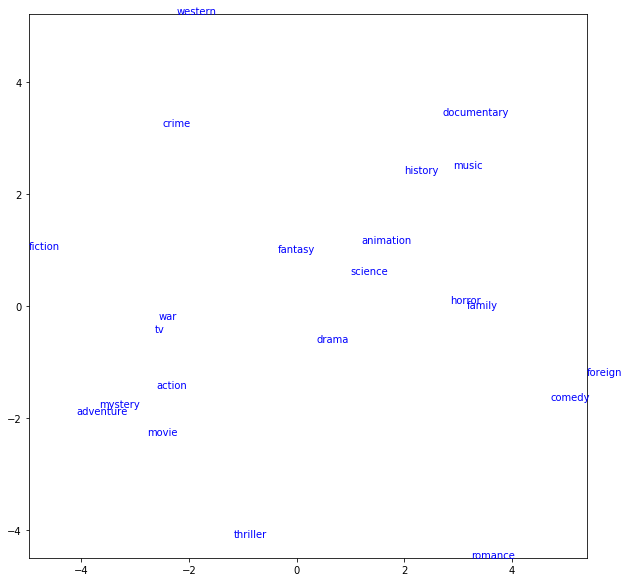

In [82]:
plt.figure(figsize=(10,10))

xs = []
ys = []

for key in genres_dict:
    i = genres_dict[key]
    x,y = G_pca[i,0], G_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,key,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

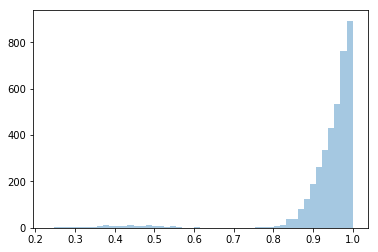

In [85]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-5.977154391854921, 7.068765630197723, -4.01937075611491, 4.807113287271427)

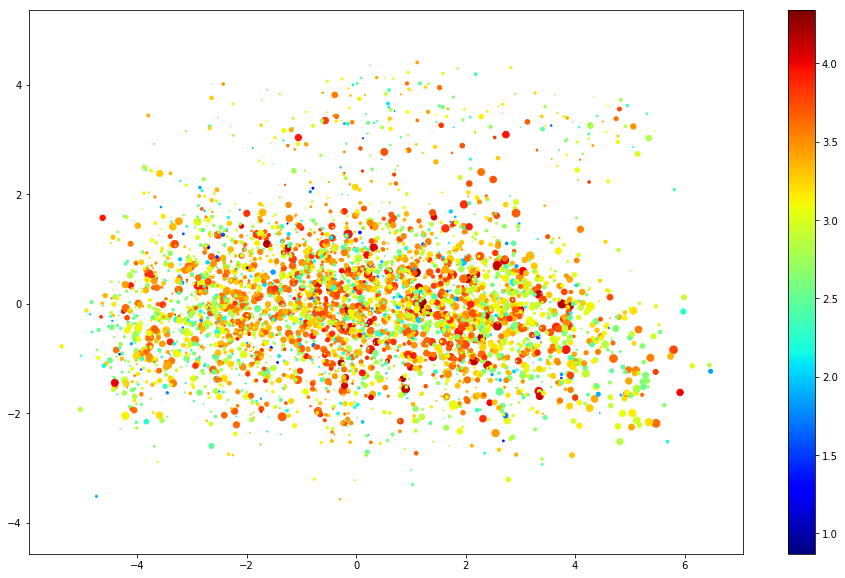

In [87]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

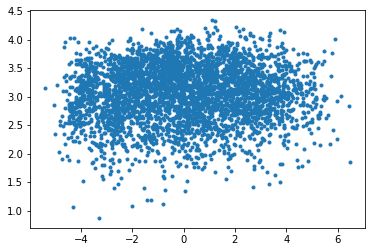

In [88]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

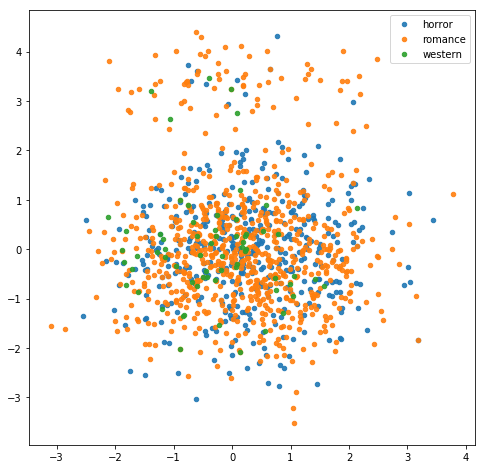

In [89]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','western']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

(-2.366426, 2.7693222)

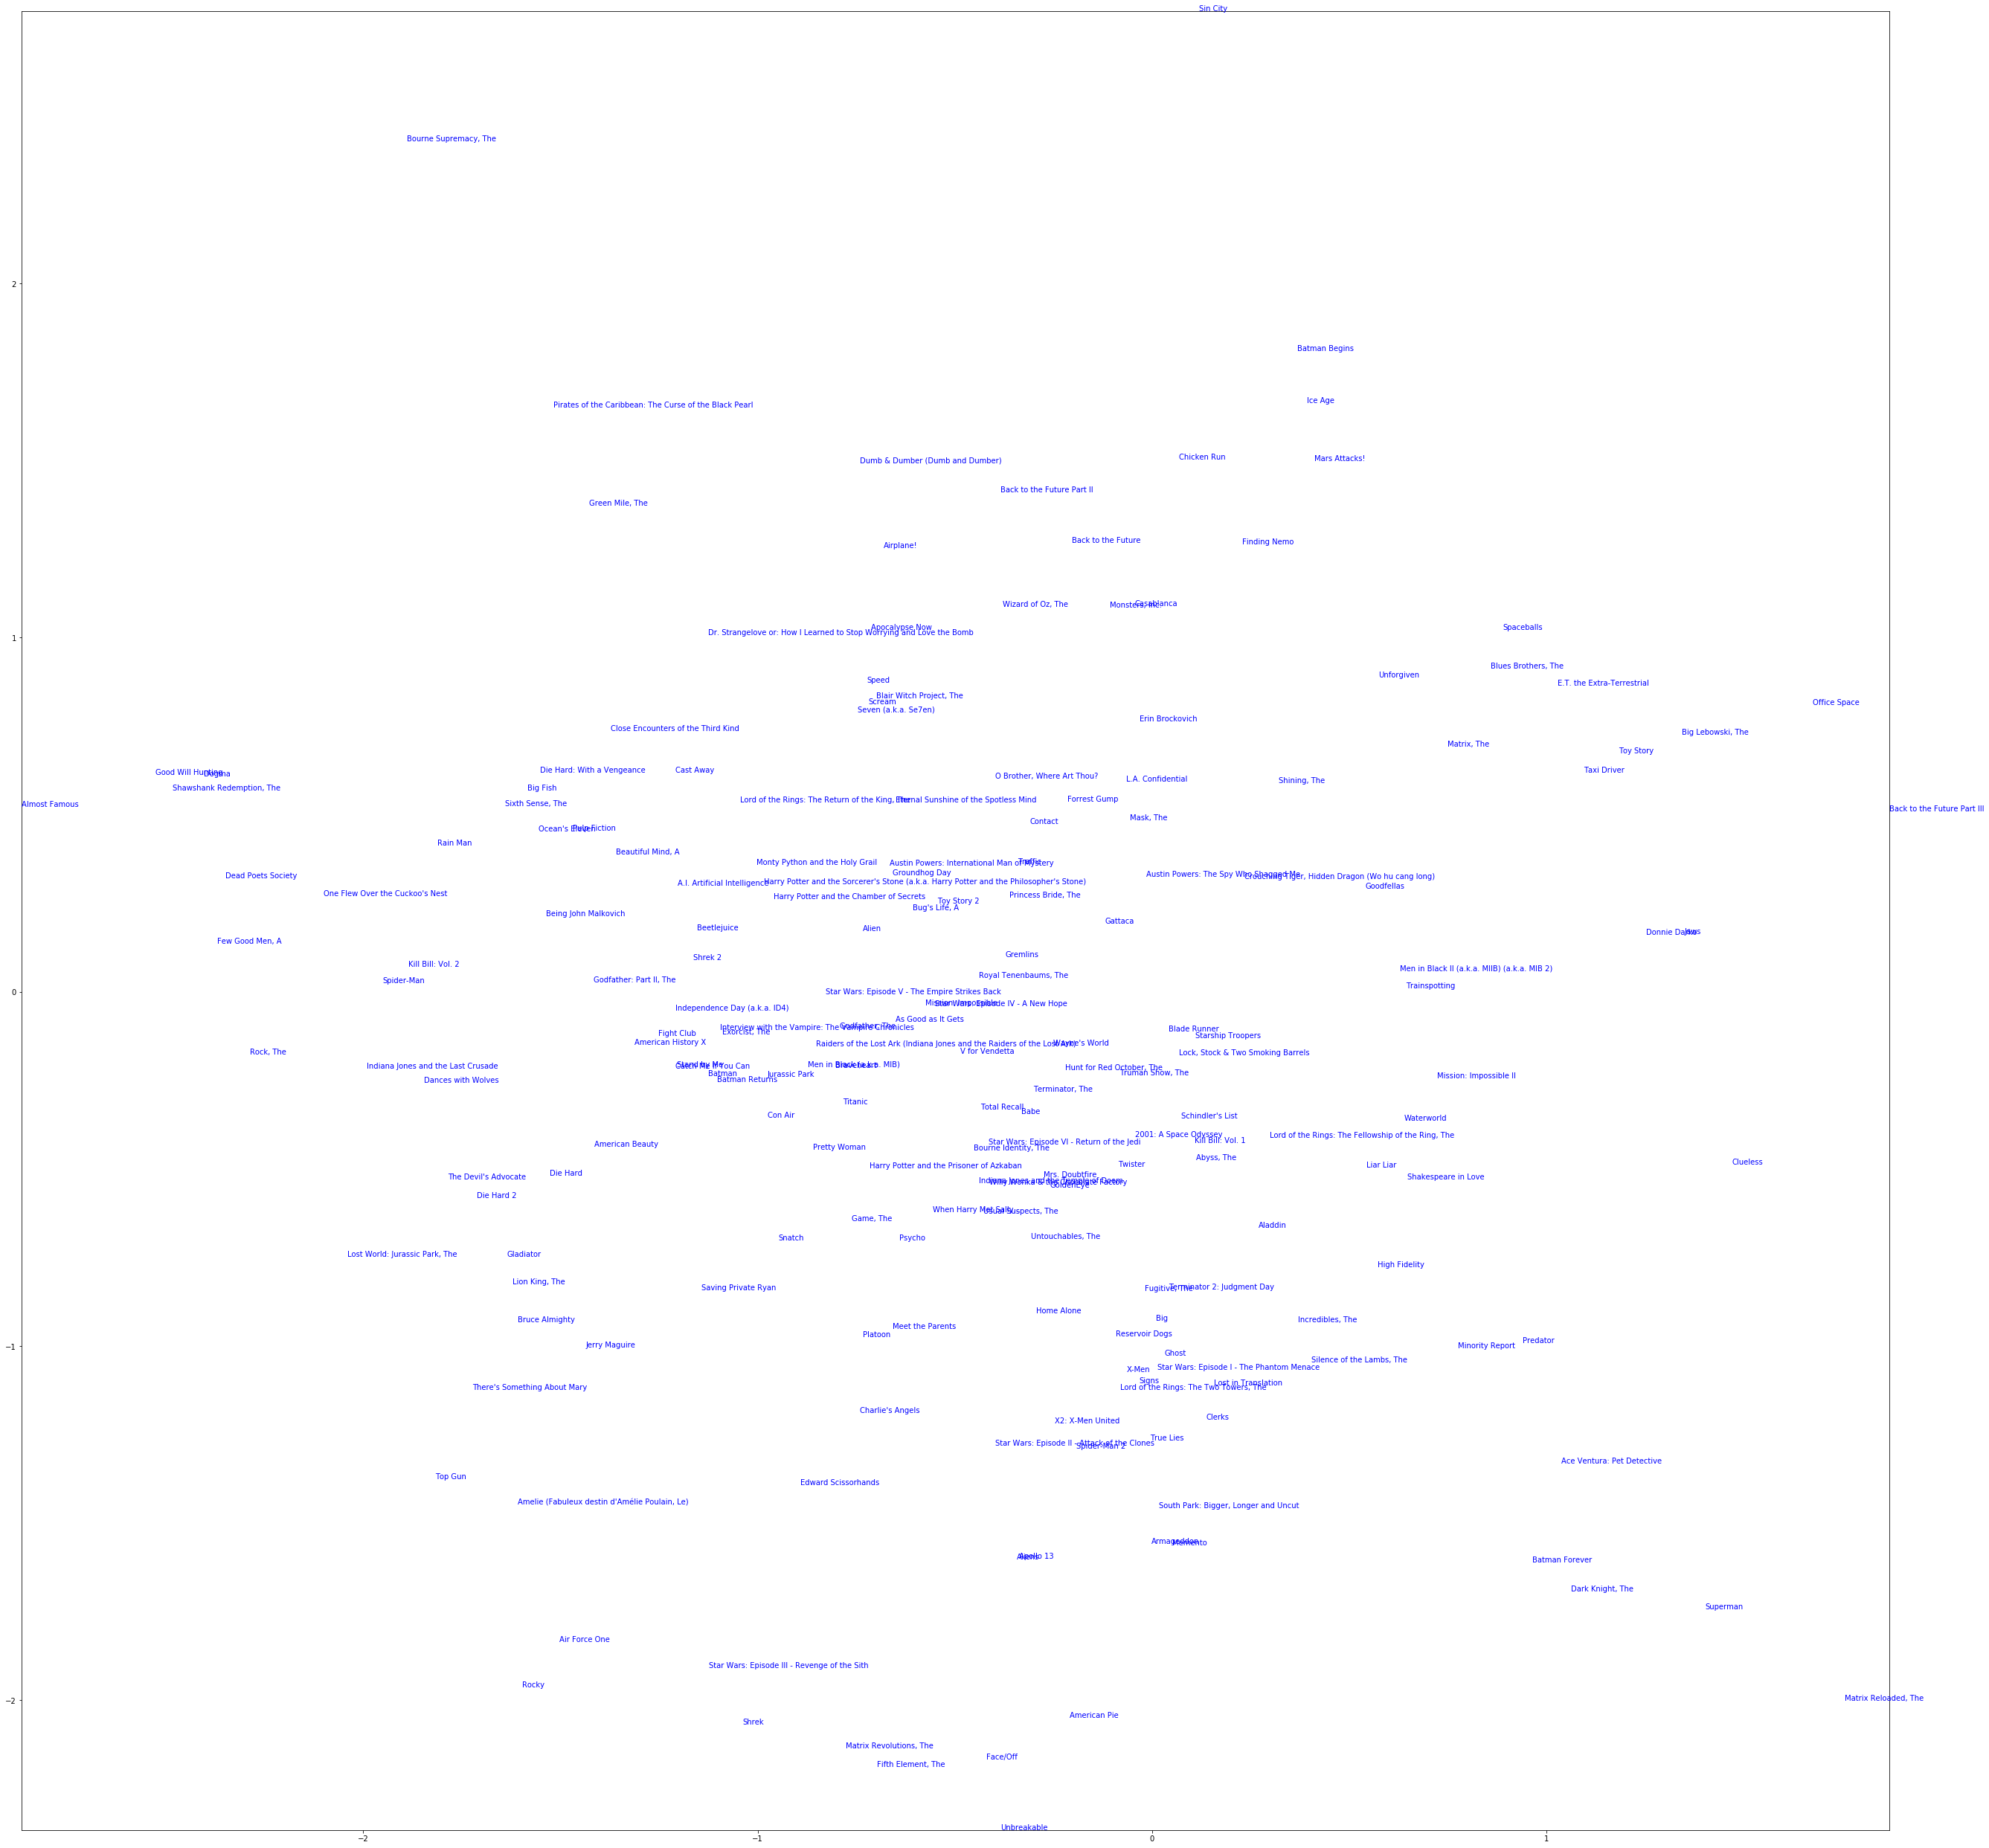

In [90]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [93]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Spy Kids 3-D: Game Over
   Battle of Shaker Heights, The
   Digimon: The Movie
   Dolphin Tale
   Maria Full of Grace (Maria, Llena eres de gracia)
   Bourne Identity, The
   AVPR: Aliens vs. Predator - Requiem
   Mortal Instruments: City of Bones, The
   Cats & Dogs
   Ladder 49
   Moonraker

Movie:Forrest Gump
   Air Bud
   Four Weddings and a Funeral
   Toy Story 2
   Singin' in the Rain
   Princess Bride, The
   About a Boy
   Love Actually
   Grudge Match
   Soul Kitchen
   It Happened One Night
   White Chicks

Movie:Back to the Future
   Spy Kids 3-D: Game Over
   Megamind
   You Don't Mess with the Zohan
   Ace Ventura: When Nature Calls
   Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)
   Flipper
   Akira
   30 Minutes or Less
   St. Trinian's
   Fear and Loathing in Las Vegas
   Bee Movie

Movie:Pulp Fiction
   Outsiders, The
   Donnie Brasco
   Godfather, The
   What Lies Beneath
   International, The
   Ripley's 

In [0]:
movie_embedding = CF.movie_embedding.weight.data.detach().cpu().numpy()
user_embedding = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
genres_weight = CF.genres_layers[0].weight.data.detach().cpu().numpy()
genres_bias = CF.genres_layers[0].bias.data.detach().cpu().numpy()

In [0]:
fc_relevance = [{},{},{}]
for ilayer in range(3):
    fc_relevance[ilayer]['weight'] = CF.fc_layers_relevance[ilayer*2].weight.data.detach().cpu().numpy()
    fc_relevance[ilayer]['bias'] = CF.fc_layers_relevance[ilayer*2].bias.data.detach().cpu().numpy()
    

In [0]:
kw_embedding_np = dict((k,v.detach().cpu().numpy()[0][0]) for (k,v) in kw_embedding.items())

In [98]:
kw_default_embedding.shape

torch.Size([1, 1, 64])

In [0]:
model_weights = {'genres_weight':genres_weight,
                'genres_bias':genres_bias,
                'genres_list': genres_list,
                'genres_dict': genres_dict,
                'movie_embedding': movie_embedding,
                'fc_relevance': fc_relevance,
                 'kw_embedding': kw_embedding_np,
                 'kw_default_embedding': kw_default_embedding[0][0].detach().numpy(),
                 'kw_set': kw_set                 
                }

In [0]:
def get_query_vector(query, model_weights):
    kws = [kw.lower() for kw in query.split(' ')]
    n = 0
    res = np.zeros(64)
    for kw in kws:
        if kw in model_weights['kw_set']:
            print(kw)
            res+=model_weights['kw_embedding'][kw]
            n+=1
    if n==0:
        return model_weights['kw_default_embedding']
    else:
        return res/n

In [0]:
def get_genre_vector(genres, model_weights):
    v = np.zeros((22,1))
    for g in genres:
        if g in model_weights['genres_dict']:
            v[model_weights['genres_dict'][g]]=1
    
    return model_weights['genres_weight'].dot(v).squeeze(1)+model_weights['genres_bias']

In [0]:
def predict(model_weights, query, user_embedding, genres):

    query_embedding = get_query_vector(query, model_weights)
    genres_embedding = get_genre_vector(genres_q, model_weights)

    final_query_em = ave_User_Em + genres_embedding + query_embedding

    relevance_em = np.concatenate((model_weights['movie_embedding'], genres_embedding.reshape(1,64).repeat(nM,axis=0), query_embedding.reshape(1,64).repeat(nM,axis=0)),axis=1)

    for i, fc in enumerate(model_weights['fc_relevance']):
        relevance_em = relevance_em.dot(fc['weight'].T)+fc['bias']
        if i<len(model_weights['fc_relevance'])-1:
            relevance_em = np.tanh(relevance_em)
        else:
            relevance_em = 1. / (1. + np.exp(-relevance_em))

    relevance_score = relevance_em.squeeze(axis=1)
    rating_score = final_query_em.dot(model_weights['movie_embedding'].T).squeeze(0)
    
    return relevance_score, rating_score

In [0]:
query = 'toy story'
genres_q = ['family','animation']

In [105]:
rel, rat = predict(model_weights, query, ave_User_Em, genres_q)

toy
story


In [0]:
ind_rel = np.argsort(rel)[::-1][:200]
ind = [ind_rel[i] for i in np.argsort(rat[ind_rel])[::-1]]

In [107]:
movie_df.iloc[list(ind)]

,index,Unnamed: 0,title,movieId,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating
3462,3462,3462,Monsters University,9531,3463,62211,2013,"family,animation",animation buscemi dan bd video billy college s...,903,3.329457,0.876356
3857,3857,3857,Central Intelligence,10434,3857,302699,2016,"action,comedy",marshall hart reunion reference thurber intell...,325,2.898462,0.938131
2619,2619,2619,Space Chimps,7972,2620,11802,2008,"family,animation",daniels jeff hines kirk aftercreditsstinger ch...,82,2.140244,1.106307
527,527,527,Oliver!,1498,527,17917,1968,"family,music,drama",oliver reed picture oliver a list from mark pa...,651,3.503840,1.007083
2103,2103,2103,My Date with Drew,6954,2104,25975,2005,documentary,camcorder barrymore with crush drew drew brian...,67,2.746269,1.038549
3039,3039,3039,Tangled,8768,3040,38757,2010,"family,animation",runner byron selfishness mother animal chamele...,1198,3.500417,0.917094
1811,1811,1811,Starsky & Hutch,5557,1812,9384,2004,"crime,comedy",jumping starsky a hutch informant footage from...,1679,2.771888,0.910518
3142,3142,3142,Winnie the Pooh,8962,3143,51162,2011,"family,animation",oppl duringcreditsstinger hunger stephen bd vi...,154,3.279221,0.985163
3119,3119,3119,Kung Fu Panda 2,8930,3120,49444,2011,"family,animation",animation woman much yuh jennifer panda black ...,797,3.227102,0.943035
1650,1650,1650,Finding Nemo,4916,1651,12,2003,"family,animation",protective anxiety harbor orphaned ellen chara...,3341,3.804250,0.849530
